In [22]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [146]:
from tqdm import tqdm

In [455]:
import math

In [69]:
mnist_train = MNIST("../datasets/", train=True, download=True)
mnist_test = MNIST("../datasets/", train=False, download=True)

In [342]:
train_X = mnist_train.data.type(torch.float)
train_y = mnist_train.targets.type(torch.uint8)

test_X = mnist_test.data.type(torch.float)
test_y = mnist_test.targets.type(torch.uint8)

In [83]:
train_X.shape, train_X.dtype, train_y.shape, train_y.dtype

(torch.Size([60000, 28, 28]), torch.float32, torch.Size([60000]), torch.uint8)

In [84]:
from random import randint

In [85]:
n_training_samples = len(train_y)

tensor([5, 9, 9, 3, 8, 6, 6, 0, 6, 3, 7, 6, 7, 1, 0, 8, 0, 4, 3, 5, 3, 3, 0, 9,
        3, 2, 2, 8, 5, 3, 8, 1], dtype=torch.uint8)
torch.Size([28, 28])


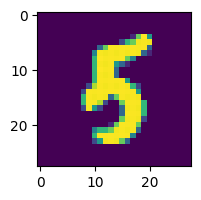

In [309]:
BS = 32

i = randint(0, n_training_samples-BS)
print(train_y[i:i+BS])

sample = train_X.data[i]

plt.figure(figsize=(2,2))
plt.imshow(sample)

print(sample.shape)

In [494]:
class DaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=(28*28), out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=10)
            #nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [176]:
model = DaModel()

pred = model.forward(sample.unsqueeze(dim=0).unsqueeze(dim=0))
loss_fn = nn.CrossEntropyLoss()

loss = loss_fn(pred, train_y[i].unsqueeze(dim=0))

loss, pred.argmax(), train_y[i]

(tensor(2.4116, grad_fn=<NllLossBackward0>),
 tensor(7),
 tensor(1, dtype=torch.uint8))

In [199]:
model = DaModel()
loss_fn = nn.CrossEntropyLoss()

sample_batch_X = train_X[10:10+BS]
sample_batch_y = train_y[10:10+BS]

pred = model.forward(sample_batch_X)

loss = loss_fn(pred, sample_batch_y)

loss, train_y[i]

(tensor(2.3953, grad_fn=<NllLossBackward0>), tensor(1, dtype=torch.uint8))

In [496]:
model = DaModel()
optim = torch.optim.SGD(params=model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
def acc_fn(pred, label):
    return (pred.argmax(dim=1) == label).sum()/len(label)

model.train()

DaModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=10, bias=True)
  )
)

  0%|                                                                                                                                                                                                     | 0/3 [00:00<?, ?it/s]

Batch: 0
Batch: 500
Batch: 1000
Batch: 1500


 33%|███████████████████████████████████████████████████████████████                                                                                                                              | 1/3 [00:03<00:07,  3.69s/it]

0.001765384222380817
100.0 %
Batch: 0
Batch: 500
Batch: 1000
Batch: 1500


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2/3 [00:06<00:02,  2.96s/it]

0.0013964853715151548
96.875 %
Batch: 0
Batch: 500
Batch: 1000
Batch: 1500


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.67s/it]

0.007674370426684618
90.625 %


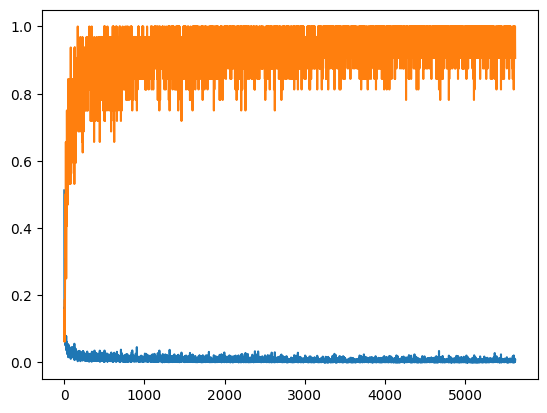

In [497]:
BS = 32

epochs = 3

losses = []
accs = []

n_batches = int(n_training_samples/BS)

for _ in tqdm(range(epochs)):
    
    for b in range(n_batches):
        
        if b % 500 == 0: 
            print("Batch:", b)
        
        i = randint(0, n_training_samples-BS)
            
        preds = model(train_X[i:i+BS])
        labels = train_y[i:i+BS]   
        
        acc = acc_fn(preds, labels)   
        loss = loss_fn(preds, labels)    
        
        losses.append(loss.item()/BS)
        accs.append(acc.item())
        
        optim.zero_grad()
        
        loss.backward()

        optim.step()
    
    
    print(losses[len(losses)-1])
    print(accs[len(accs)-1]*100, "%")
    
plt.plot(losses)
plt.plot(accs)

In [498]:
i = randint(0, 10000)

model.eval()

(model(test_X).argmax(dim=1) == test_y).sum()

tensor(9470)

In [500]:
# logsoftmax -> NLLL
class DaModel_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=(28*28), out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=10),
            nn.LogSoftmax(dim=1)
        )      
    def forward(self, x): return self.layer_stack(x)

# logsoftmax -> crossentropyloss
class DaModel_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=(28*28), out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=10),
            nn.LogSoftmax(dim=1)
        )      
    def forward(self, x): return self.layer_stack(x)

# softmax -> crossentropyloss
class DaModel_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=(28*28), out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=10)
            #nn.LogSoftmax(dim=1)
        )      
    def forward(self, x): return self.layer_stack(x)

In [570]:
def do_train(model, loss_fn, optim):  
    model.train()
    BS = 128
    epochs = 3
    losses = []
    accs = []
    n_batches = int(n_training_samples/BS)
    for _ in tqdm(range(epochs)):
        for b in range(n_batches):
            i = randint(0, n_training_samples-BS)
            preds = model(train_X[i:i+BS])
            labels = train_y[i:i+BS]   
            acc = acc_fn(preds, labels)   
            loss = loss_fn(preds, labels)    
            losses.append(loss.item()/BS)
            accs.append(acc.item())
            optim.zero_grad()
            loss.backward()
            optim.step()

        #print(losses[len(losses)-1])
        #print(accs[len(accs)-1]*100, "%")       
    return {"model": model, "losses": losses, "accs": accs}

def do_eval(model):
    model.eval()
    return (model.forward(test_X).argmax(dim=1)==test_y).sum() / len(test_y)

In [565]:
model1 = DaModel_1()
optim_1 = torch.optim.SGD(params=model1.parameters(), lr=0.001)
loss_fn_1 = nn.NLLLoss()


model1_res = train(model1, loss_fn_1, optim_1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.74it/s]


In [558]:
model2 = DaModel_2()
optim_2 = torch.optim.SGD(params=model2.parameters(), lr=0.001)
loss_fn_2 = nn.CrossEntropyLoss()


model2_res = train(model2, loss_fn_2, optim_2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.32it/s]


In [566]:
model3 = DaModel_3()
optim_3 = torch.optim.SGD(params=model3.parameters(), lr=0.001)
loss_fn_3 = nn.CrossEntropyLoss()


model3_res = train(model3, loss_fn_3, optim_3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


tensor(0.9278)
tensor(0.9259)
tensor(0.9266)


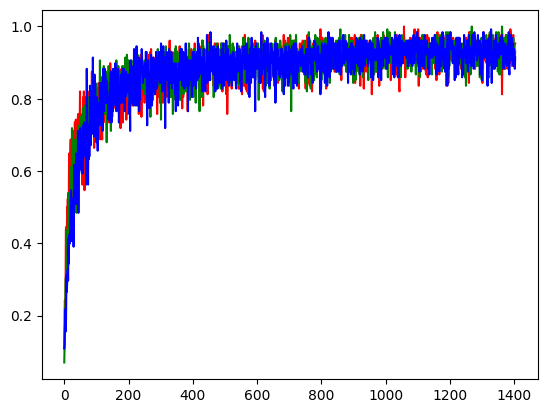

In [571]:
models = [model1_res, model2_res, model3_res]

colors = ['r', 'g', 'b']

for i, model in enumerate(models):
    plt.plot(model['accs'], c=colors[i])
    print(do_eval(model['model']))
    
